In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

In [2]:
import numpy as np
import pandas as pd
import os
import random
import cv2
import imutils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vaibhao/handwritten-characters")

print("Path to dataset files:", path)

In [ ]:
base_dir = os.getcwd()
train_dir = os.path.join(base_dir, "../data/handwritten-characters/Train/")
val_dir = os.path.join(base_dir, "../data/handwritten-characters/Validation/")
img_size = 32
non_chars = ["#", "$", "&", "@"]

In [4]:
train_data, val_data = [], []

for path, data_list, limit in [(train_dir, train_data, 4000), (val_dir, val_data, 1000)]:
    for label in os.listdir(path):
        if label in non_chars:
            continue
        count = 0
        sub_dir = os.path.join(path, label)
        for file in os.listdir(sub_dir):
            count += 1
            if count > limit:
                break
            img = cv2.imread(os.path.join(sub_dir, file), 0)
            img = cv2.resize(img, (img_size, img_size))
            data_list.append([img, label])

In [5]:
print(len(train_data), len(val_data))

140000 15209


In [6]:
random.shuffle(train_data)
random.shuffle(val_data)

In [7]:
train_X = [features for features, label in train_data]
train_Y = [label for features, label in train_data]
val_X = [features for features, label in val_data]
val_Y = [label for features, label in val_data]

In [8]:
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y = LB.transform(val_Y)

In [9]:
train_X = np.array(train_X, dtype=np.float32) / 255.0
train_X = train_X.reshape(-1, 1, 32, 32)

val_X = np.array(val_X, dtype=np.float32) / 255.0
val_X = val_X.reshape(-1, 1, 32, 32)

print(train_X.shape,val_X.shape)

(140000, 1, 32, 32) (15209, 1, 32, 32)


In [10]:
train_X = torch.tensor(train_X)
val_X = torch.tensor(val_X)

print(train_X.shape,val_X.shape)

torch.Size([140000, 1, 32, 32]) torch.Size([15209, 1, 32, 32])


In [11]:
train_Y = torch.tensor(train_Y, dtype=torch.float32)
val_Y = torch.tensor(val_Y, dtype=torch.float32)

print(train_Y.shape,val_Y.shape)

torch.Size([140000, 35]) torch.Size([15209, 35])


In [12]:
train_loader = DataLoader(TensorDataset(train_X, train_Y), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(val_X, val_Y), batch_size=32, shuffle=False)


In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(32, 64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(64, 128, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Dropout(0.25),
    nn.Flatten(),
    nn.Linear(128 * 2 * 2, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 35),  # Assuming 35 classes
    nn.Softmax(dim=1)
)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Dropout(p=0.25, inplace=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=512, out_features=128, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.2, inplace=False)
  (14): Linear(in_features=128, out_features=35, bias=True)
  (15): Softmax(dim=1)
)

In [15]:
print(device)

cuda


In [17]:
!pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable


In [18]:
from torchsummary import summary

summary(model, input_size=(1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             320
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 5, 5]          73,856
              ReLU-8            [-1, 128, 5, 5]               0
         MaxPool2d-9            [-1, 128, 2, 2]               0
          Dropout-10            [-1, 128, 2, 2]               0
          Flatten-11                  [-1, 512]               0
           Linear-12                  [-1, 128]          65,664
             ReLU-13                  [-1, 128]               0
          Dropout-14                  [

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        _, actual = torch.max(labels, 1)
        total += labels.size(0)
        correct += (predicted == actual).sum().item()

    train_acc = correct / total
    train_accuracies.append(train_acc)
    train_losses.append(running_loss / len(train_loader))

    # Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, torch.max(labels, 1)[1])
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            _, actual = torch.max(labels, 1)
            val_total += labels.size(0)
            val_correct += (predicted == actual).sum().item()

    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Accuracy: {100 * train_acc:.2f}%, Val_Loss: {val_loss:.4f}, Val_Accuracy: {val_acc * 100:.2f}%")

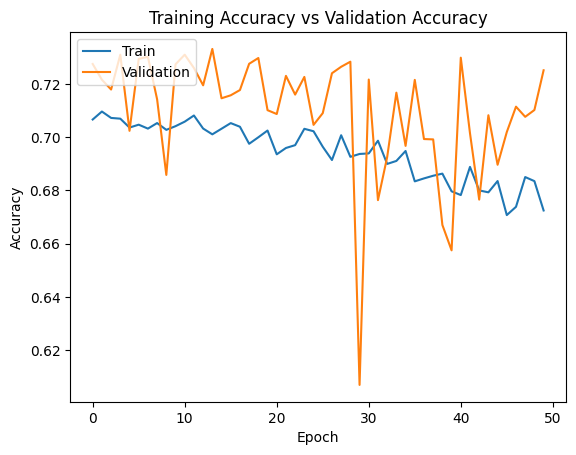

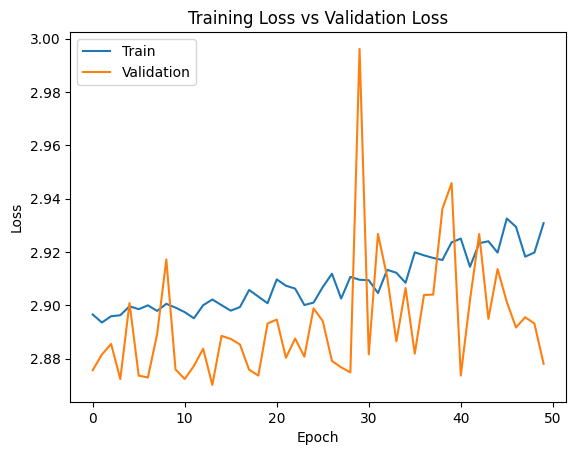

In [22]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Padding 추가하여 모델 재생성 & softmax와 CrossEntropyLoss()와의 충돌 제거

In [38]:

# 모델 정의 (Softmax 제거!)
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.25),
    nn.Flatten(),
    nn.Linear(128 * 4 * 4, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 35)  # 마지막 Softmax 제거!
)

model.to(device)
summary(model, input_size=(1, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             320
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
              ReLU-8            [-1, 128, 8, 8]               0
         MaxPool2d-9            [-1, 128, 4, 4]               0
          Dropout-10            [-1, 128, 4, 4]               0
          Flatten-11                 [-1, 2048]               0
           Linear-12                  [-1, 128]         262,272
             ReLU-13                  [-1, 128]               0
          Dropout-14                  [

In [41]:
# 결과 저장용 리스트
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 안전하게 정수 인덱스로 변환
        if labels.ndim == 2 and labels.size(1) > 1:
            labels = torch.argmax(labels, dim=1)
        labels = labels.long()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_accuracies.append(train_acc)
    train_losses.append(running_loss / len(train_loader))

    # Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            if labels.ndim == 2 and labels.size(1) > 1:
                labels = torch.argmax(labels, dim=1)
            labels = labels.long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1:2d} | "
          f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc*100:.2f}%")

Epoch  1 | Train Loss: 0.6894 | Train Acc: 78.24% | Val Loss: 0.3398 | Val Acc: 88.61%
Epoch  2 | Train Loss: 0.4068 | Train Acc: 86.53% | Val Loss: 0.2952 | Val Acc: 89.90%
Epoch  3 | Train Loss: 0.3496 | Train Acc: 88.35% | Val Loss: 0.2796 | Val Acc: 90.64%
Epoch  4 | Train Loss: 0.3174 | Train Acc: 89.49% | Val Loss: 0.2783 | Val Acc: 90.68%
Epoch  5 | Train Loss: 0.2914 | Train Acc: 90.18% | Val Loss: 0.2941 | Val Acc: 89.40%
Epoch  6 | Train Loss: 0.2759 | Train Acc: 90.64% | Val Loss: 0.2599 | Val Acc: 91.57%
Epoch  7 | Train Loss: 0.2617 | Train Acc: 91.15% | Val Loss: 0.2725 | Val Acc: 89.22%
Epoch  8 | Train Loss: 0.2508 | Train Acc: 91.41% | Val Loss: 0.2368 | Val Acc: 91.75%
Epoch  9 | Train Loss: 0.2411 | Train Acc: 91.62% | Val Loss: 0.2554 | Val Acc: 91.10%
Epoch 10 | Train Loss: 0.2348 | Train Acc: 91.80% | Val Loss: 0.2614 | Val Acc: 90.82%
Epoch 11 | Train Loss: 0.2282 | Train Acc: 91.95% | Val Loss: 0.2345 | Val Acc: 92.29%
Epoch 12 | Train Loss: 0.2219 | Train Acc: 

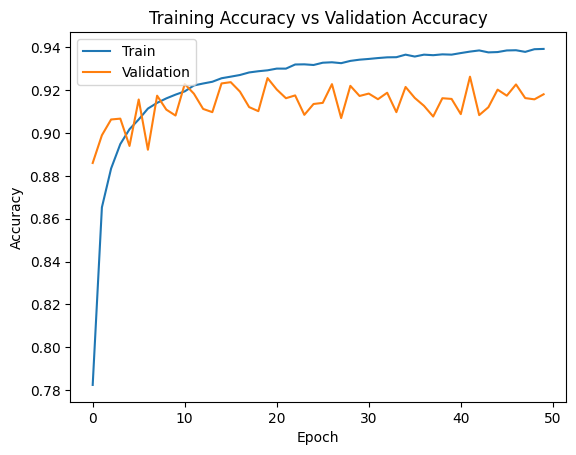

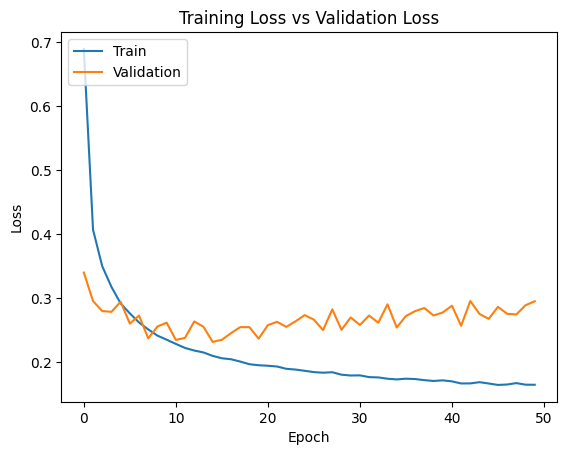

In [42]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [28]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("landlord/handwriting-recognition")

print("Path to dataset files:", path)

/home/patrick/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/patrick/.cache/kagglehub/datasets/landlord/handwriting-recognition/versions/1


In [43]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [44]:
def get_letters(img_path):
    letters = []
    image = cv2.imread(img_path)

    if image is None:
        raise ValueError(f"이미지를 읽을 수 없습니다: {img_path}")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]

    for c in cnts:
        if cv2.contourArea(c) > 10:
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

            roi = gray[y:y + h, x:x + w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            thresh = cv2.resize(thresh, (32, 32), interpolation=cv2.INTER_CUBIC)
            thresh = thresh.astype("float32") / 255.0
            thresh = np.expand_dims(thresh, axis=0)     # (1, 32, 32)
            thresh = np.expand_dims(thresh, axis=0)     # (1, 1, 32, 32)

            tensor_input = torch.tensor(thresh, dtype=torch.float32).to(device)
            with torch.no_grad():
                output = model(tensor_input)
                pred_index = torch.argmax(output, dim=1).item()
                letter = LB.classes_[pred_index]
                letters.append(letter)

    return letters, image

# plt.imshow(image)

In [45]:
def get_word(letter):
    word = "".join(letter)
    return word

WMYWY6VCV71WMIJW


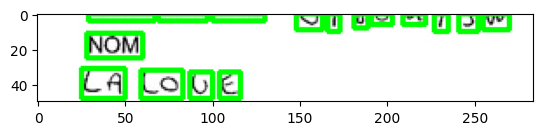

In [ ]:
letter,image = get_letters("../data/handwriting-recognition/versions/1/train_v2/train/TRAIN_00004.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

LIL0U


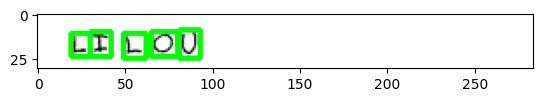

In [ ]:
letter,image = get_letters("../data/handwriting-recognition/versions/1/train_v2/train/TRAIN_00023.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

JAFFEUX


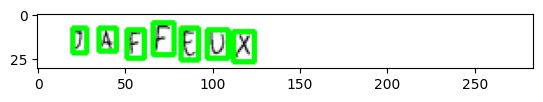

In [ ]:
letter,image = get_letters("../data/handwriting-recognition/versions/1/train_v2/train/TRAIN_00030.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

RUPP


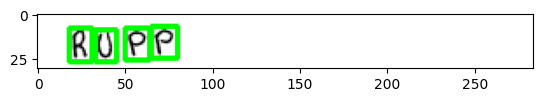

In [ ]:
letter,image = get_letters("../data/handwriting-recognition/versions/1/validation_v2/validation/VALIDATION_0005.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)